<a href="https://colab.research.google.com/github/henrygas/tensorflow_2_learn/blob/master/tensorflow_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.15.0-rc3


In [0]:
mnist = input_data.read_data_sets("./")

print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000,)
(5000, 784)
(5000,)
(10000, 784)
(10000,)


可以看到images里面有数量不等的图片，每张图片是28$\times$28长度的一维向量，所以用的时候需要将它转化为28$\times$28的图片。labels中则是图片对应的数字的值。

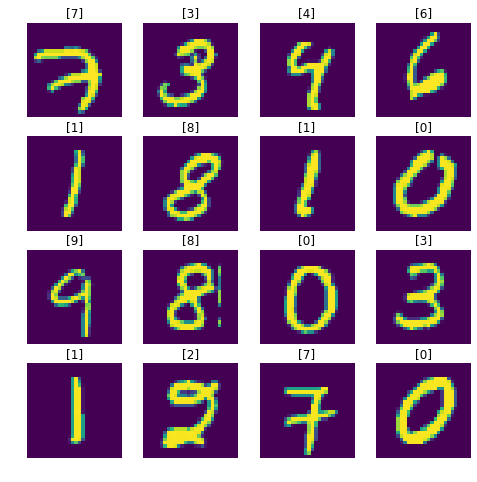

In [0]:
plt.figure(figsize=(8, 8))

for idx in range(16):
  plt.subplot(4, 4, idx + 1)
  plt.axis("off")
  plt.title("[{}]".format(mnist.train.labels[idx]))
  plt.imshow(mnist.train.images[idx].reshape((28, 28)))

接下来，定义用于训练的网络，首先定义网络的输入。
<br/><br/>
这里我们直接使用上面的数据作为输入，所以定义两个placeholder分别用于图像和label数据，另外，定义一个float类型的变量用于设置学习率。
<br/><br/>
为了让网络更高效的运行，多个数据会被组织成一个batch送入网络，两个placeholder的第一个维度就是batchsize，因为我们这里还没有确定batchsize，所以第一个维度留空。

In [0]:
x = tf.placeholder("float", [None, 784])
y = tf.placeholder("int64", [None])
learning_rate = tf.placeholder("float")

In [0]:
def initialize(shape, stddev=0.1):
  """
  :param shape: 输入张量的维度形状
  :param stddev: 标准差
  :return 生成指定维度的张量，元素值满足正态分布 N(0, stddev), 且元素都在正负2 * stddev范围内
  """
  return tf.truncated_normal(shape, stddev=0.1)

L1_units_count = 100
W_1 = tf.Variable(initialize([784, L1_units_count]))
b_1 = tf.Variable(initialize([L1_units_count]))
logits_1 = tf.matmul(x, W_1) + b_1
output_1 = tf.nn.relu(logits_1)

L2_units_count = 10
W_2 = tf.Variable(initialize([L1_units_count, L2_units_count]))
b_2 = tf.Variable(initialize([L2_units_count]))
logits_2 = tf.matmul(output_1, W_2) + b_2

logits = logits_2

接下来定义loss和用于优化网络的优化器。loss计算使用了sparse_softmax_cross_entropy_with_logits，这样做的好处是labels可以不用手动做one_hot省了一些麻烦。这里使用了sgd优化器，学习率为可以根据需要设定。
<br/><br/>
试试看，增大减小学习率，换个优化器再训练会发生什么。

In [0]:
cross_entropy_loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(cross_entropy_loss)

需要注意的是，上面的网络，最后输出的是未经softmax的原始logits，而不是概率分布，要想看到概率分布，还需要做一下softmax.
<br/><br/>
将输出的结果与正确结果进行对比，即可得到我们的网络输出结果的准确率。

In [0]:
pred = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(pred, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

saver用于保存或恢复训练的模型。

In [0]:
batch_size = 32
training_step = 1000

saver = tf.train.Saver()

以上定义的所有操作，均为计算图Graph，也就是仅仅是定义了网络的结构，实际需要运行的话，还需要创建一个session，并将数据填入网络中。

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  # 定义验证集与测试集
  validate_data = {
      x: mnist.validation.images,
      y: mnist.validation.labels
  }
  test_data = {
      x: mnist.test.images,
      y: mnist.test.labels
  }

  for i in range(training_step):
    xs, ys = mnist.train.next_batch(batch_size)
    _, loss = sess.run(
        [optimizer, cross_entropy_loss],
        feed_dict = {
            x: xs,
            y: ys,
            learning_rate: 0.3
        }
    )

    # 每100次训练打印一次损失值与验证准确率
    if i > 0 and i % 100 == 0:
      validate_accuracy = sess.run(accuracy, feed_dict=validate_data)
      print("after {} training steps, the loss is {}, the validation accuracy is {}".format(
          i, loss, validate_accuracy
      ))
      saver.save(sess, "./model.ckpt", global_step=i)

  print("the training is finished!")
  # 最终的测试准确率
  acc = sess.run(accuracy, feed_dict=test_data)
  print("the test accuracy is:{}".format(acc))

after 100 training steps, the loss is 0.3007691502571106, the validation accuracy is 0.8791999816894531
after 200 training steps, the loss is 0.18718621134757996, the validation accuracy is 0.9085999727249146
after 300 training steps, the loss is 0.23296503722667694, the validation accuracy is 0.9223999977111816
after 400 training steps, the loss is 0.23762854933738708, the validation accuracy is 0.9215999841690063
after 500 training steps, the loss is 0.3668045997619629, the validation accuracy is 0.9247999787330627
after 600 training steps, the loss is 0.23218177258968353, the validation accuracy is 0.9394000172615051
Instructions for updating:
Use standard file APIs to delete files with this prefix.
after 700 training steps, the loss is 0.3196142911911011, the validation accuracy is 0.9466000199317932
after 800 training steps, the loss is 0.30492380261421204, the validation accuracy is 0.9455999732017517
after 900 training steps, the loss is 0.07111744582653046, the validation accur

下面，用我们训练的模型做一个测试。

INFO:tensorflow:Restoring parameters from ./model.ckpt-900
0.9375


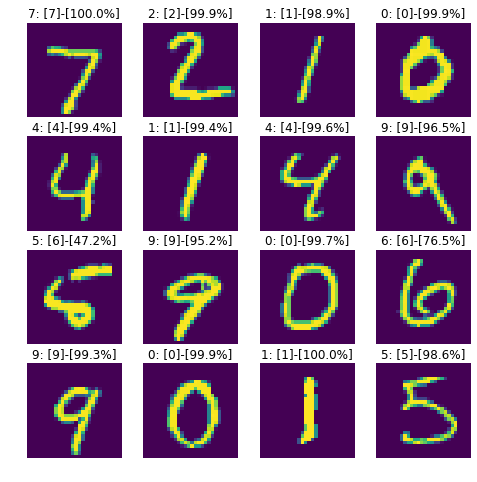

In [0]:
with tf.Session() as sess:
  ckpt = tf.train.get_checkpoint_state("./")
  if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    final_pred, acc = sess.run(
        [pred, accuracy],
        feed_dict={
            x: mnist.test.images[:16],
            y: mnist.test.labels[:16]
        }
    )
    orders = np.argsort(final_pred)
    plt.figure(figsize=(8, 8))
    print(acc)
    for idx in range(16):
      order = orders[idx, :][-1]
      prob = final_pred[idx, :][order]
      plt.subplot(4, 4, idx + 1)
      plt.axis("off")
      plt.title("{}: [{}]-[{:.1f}%]".format(mnist.test.labels[idx], order, prob * 100))
      plt.imshow(mnist.test.images[idx].reshape((28, 28)))
  else:
    pass

以作业提供的参数运行出来的结果，只看上面几个数字还是很不错的，但是总体准确率不太理想。